# Environment setup

In [0]:
# Connect to Google Drive

from google.colab import drive
drive.mount('/content/gdrive')

In [0]:
# Copy the dataset from Google Drive to local

!cp "/content/gdrive/My Drive/CBIS_DDSM.zip" .
!unzip -qq CBIS_DDSM.zip
!rm CBIS_DDSM.zip
cbis_path = 'CBIS_DDSM'

In [0]:
# Import libraries

%tensorflow_version 1.x
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler, Callback
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop, SGD, Adam, Adadelta, Adagrad, Adamax, Nadam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import plot_model

# Data pre-processing

In [0]:
def load_training():
    """
    Load the training set (excluding baseline patches)
    """
    images = np.load(os.path.join(cbis_path, 'numpy data', 'train_tensor.npy'))[1::2]
    labels = np.load(os.path.join(cbis_path, 'numpy data', 'train_labels.npy'))[1::2]
    return images, labels


def load_testing():
    """
    Load the test set (abnormalities patches and labels, no baseline)
    """
    images = np.load(os.path.join(cbis_path, 'numpy data', 'public_test_tensor.npy'))[1::2]
    labels = np.load(os.path.join(cbis_path, 'numpy data', 'public_test_labels.npy'))[1::2]
    return images, labels


def remap_label(l):
    """
    Remap the labels to 0->benign 1->malignant
    """
    if l == 1 or l == 3:
        return 0
    elif l == 2 or l == 4:
        return 1
    else:
        print("[WARN] Unrecognized label (%d)" % l)
        return None

The data is prepared following these steps:


1.   Import the training and testing data from numpy arrays
2.   Remove the images and labels related to baseline patches (even indices in the arrays)
3.   Adjust the labels for the binary classification problem, so that 0 corresponds to 'benign' and 1 maps to 'malignant'
4.   Normalize the pixels to be in the range (0-1) floating point
5.   Shuffle the training set (and labels accordingly, of course)
6.   Split the training data into 'training' and 'validation' subsets
7.   Build Keras generators for training and validation data

In [0]:
# Load training and test images (abnormalities only, no baseline)
train_images, train_labels= load_training()
test_images, test_labels= load_testing()

# Number of images
n_train_img = train_images.shape[0]
n_test_img = test_images.shape[0]
print("Train size: %d \t Test size: %d" % (n_train_img, n_test_img))

# Compute width and height of images
img_w = train_images.shape[1]
img_h = train_images.shape[2]
print("Image size: %dx%d" % (img_w, img_h))

# Remap labels
train_labels = np.array([remap_label(l) for l in train_labels])
test_labels = np.array([remap_label(l) for l in test_labels])

# Create a new dimension for color in the images arrays
train_images = train_images.reshape((n_train_img, img_w, img_h, 1))
test_images = test_images.reshape((n_test_img, img_w, img_h, 1))

# Convert from 16-bit (0-65535) to float (0-1)
train_images = train_images.astype('uint16') / 65535
test_images = test_images.astype('uint16') / 65535

# Shuffle the training set (originally sorted by label)
perm = np.random.permutation(n_train_img)
train_images = train_images[perm]
train_labels = train_labels[perm]

# Create a generator for training images
train_datagen = ImageDataGenerator(
    validation_split=0.2,
    rotation_range=180,
    shear_range=10,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='reflect'
)

# Fit the generator with some images
train_datagen.fit(train_images)

# Split train images into actual training and validation
train_generator = train_datagen.flow(train_images, train_labels, batch_size=128, subset='training')
validation_generator = train_datagen.flow(train_images, train_labels, batch_size=128, subset='validation')

Train size: 2676 	 Test size: 336
Image size: 150x150


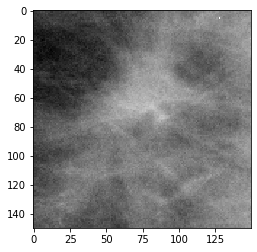

Label: 1


In [0]:
# Visualize one image from the dataset and its label, just to make sure the data format is correct

idx = 0

plt.imshow(train_images[idx][:,:,0], cmap='gray')
plt.show()

print("Label: " + str(train_labels[idx]))

## Run 1

In [0]:
# Model 1

model_1 = models.Sequential()
model_1.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=(150, 150, 1)))
model_1.add(layers.MaxPooling2D((2, 2)))
model_1.add(layers.Conv2D(128, (3, 3), activation='relu'))
model_1.add(layers.MaxPooling2D((2, 2)))
model_1.add(layers.Conv2D(256, (3, 3), activation='relu'))
model_1.add(layers.MaxPooling2D((2, 2)))
model_1.add(layers.Flatten())
model_1.add(layers.Dense(64, activation='relu'))
model_1.add(layers.Dropout(0.5))
model_1.add(layers.Dense(1, activation='sigmoid'))

model_1.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 64)      640       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 128)       73856     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 256)       295168    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 256)       0         
_________________________________________

In [0]:
# Early stopping (stop training after the validation loss reaches the minimum)
earlystopping = EarlyStopping(monitor='val_loss', mode='min', patience=80, verbose=1)

# Callback for checkpointing
checkpoint = ModelCheckpoint('model_1_benmal_best.h5', 
        monitor='val_loss', mode='min', verbose=1, 
        save_best_only=True, save_freq='epoch'
)

# Compile the model
model_1.compile(optimizer=RMSprop(learning_rate=0.001, decay=1e-3), loss='binary_crossentropy', metrics=['accuracy'])

# Train
history_1 = model_1.fit_generator(
        train_generator,
        steps_per_epoch=int(0.8*n_train_img) // 128,
        epochs=500,
        validation_data=validation_generator,
        callbacks=[checkpoint],
        shuffle=True,
        verbose=1,
        initial_epoch=0
)

# Save
models.save_model(model_1, 'model_1_benmal_end.h5')
!cp model* "/content/gdrive/My Drive/models/"

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/500
 5/16 [========>.....................] - ETA: 2s - loss: 0.6958 - acc: 0.4449
Epoch 00001: val_loss improved from inf to 0.69575, saving model to model_1_benmal_best.h5
16/16 [==============================] - 15s 966ms/step - loss: 1.1912 - acc: 0.5544 - val_loss: 0.6958 - val_acc: 0.4449
Epoch 2/500
 4/16 [======>.......................] - ETA: 3s - loss: 0.6817 - acc: 0.5645
Epoch 00002: val_loss improved from 0.69575 to 0.68203, saving model to model_1_benmal_best.h5
16/16 [==============================] - 6s 365ms/step - loss: 0.6879 - acc: 0.5877 - val_loss: 0.6820 - val_acc: 0.5664
Epoch 3/500
 4/16 [======>.......................] - ETA: 3s - loss: 0.6842 - acc: 0.5625
Epoch 00003: val_loss improved from 0.68203 to 0.68104, saving model to model_1_benmal_best.h5
16/16 [==============================] - 6s 374ms/step - loss: 0.6927 - acc: 0.5902 - val_loss: 0.6810 - val_acc

In [0]:
# History of accuracy and loss
tra_loss_1 = history_1.history['loss']
tra_acc_1 = history_1.history['acc']
val_loss_1 = history_1.history['val_loss']
val_acc_1 = history_1.history['val_acc']

# Total number of epochs training
epochs_1 = range(1, len(tra_acc_1)+1)
end_epoch_1 = len(tra_acc_1)

# Epoch when reached the validation loss minimum
opt_epoch_1 = val_loss_1.index(min(val_loss_1)) + 1

# Loss and accuracy on the validation set
end_val_loss_1 = val_loss_1[-1]
end_val_acc_1 = val_acc_1[-1]
opt_val_loss_1 = val_loss_1[opt_epoch_1-1]
opt_val_acc_1 = val_acc_1[opt_epoch_1-1]

# Loss and accuracy on the test set
opt_model_1 = models.load_model('model_1_benmal_best.h5')
test_loss_1, test_acc_1 = model_1.evaluate(test_images, test_labels, verbose=False)
opt_test_loss_1, opt_test_acc_1 = opt_model_1.evaluate(test_images, test_labels, verbose=False)
opt_pred_1 = opt_model_1.predict([test_images, test_labels])
pred_classes_1 = np.rint(opt_pred_1)

print("Model 1\n")

print("Epoch [end]: %d" % end_epoch_1)
print("Epoch [opt]: %d" % opt_epoch_1)
print("Valid accuracy [end]: %.4f" % end_val_acc_1)
print("Valid accuracy [opt]: %.4f" % opt_val_acc_1)
print("Test accuracy [end]:  %.4f" % test_acc_1)
print("Test accuracy [opt]:  %.4f" % opt_test_acc_1)
print("Valid loss [end]: %.4f" % end_val_loss_1)
print("Valid loss [opt]: %.4f" % opt_val_loss_1)
print("Test loss [end]:  %.4f" % test_loss_1)
print("Test loss [opt]:  %.4f" % opt_test_loss_1)

print(classification_report(test_labels, pred_classes_1, digits=4))

Model 1

Epoch [end]: 500
Epoch [opt]: 425
Valid accuracy [end]: 0.6860
Valid accuracy [opt]: 0.6991
Test accuracy [end]:  0.6667
Test accuracy [opt]:  0.6488
Valid loss [end]: 0.5767
Valid loss [opt]: 0.5274
Test loss [end]:  0.6120
Test loss [opt]:  0.6331
              precision    recall  f1-score   support

           0     0.7701    0.6575    0.7094       219
           1     0.4966    0.6325    0.5564       117

    accuracy                         0.6488       336
   macro avg     0.6333    0.6450    0.6329       336
weighted avg     0.6748    0.6488    0.6561       336



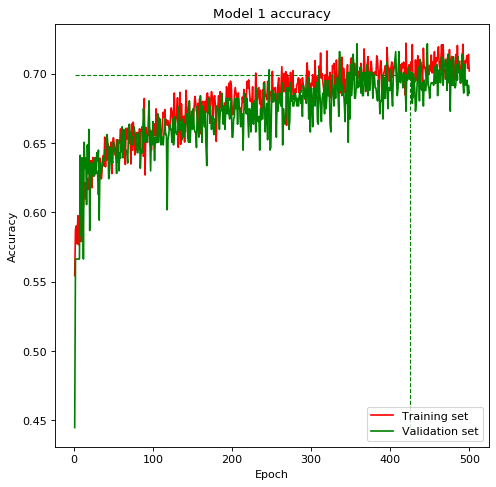

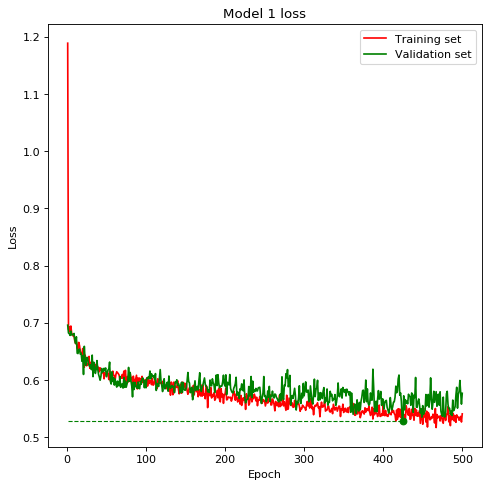

In [0]:
# Model accuracy
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('Model 1 accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.plot(epochs_1, tra_acc_1, 'r', label='Training set')
plt.plot(epochs_1, val_acc_1, 'g', label='Validation set')
plt.plot(opt_epoch_1, val_acc_1[opt_epoch_1-1], 'go')
plt.vlines(opt_epoch_1, min(val_acc_1), opt_val_acc_1, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_acc_1, 1, opt_epoch_1, linestyle="dashed", color='g', linewidth=1)
plt.legend(loc='lower right')

# Model loss
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('Model 1 loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(epochs_1, tra_loss_1, 'r', label='Training set')
plt.plot(epochs_1, val_loss_1, 'g', label='Validation set')
plt.plot(opt_epoch_1, val_loss_1[opt_epoch_1-1], 'go')
plt.vlines(opt_epoch_1, min(val_loss_1), opt_val_loss_1, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_loss_1, 1, opt_epoch_1, linestyle="dashed", color='g', linewidth=1)
plt.legend();

## Run 2

In [0]:
# Model 2

model_2 = models.Sequential()
model_2.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=(150, 150, 1)))
model_2.add(layers.MaxPooling2D((2, 2)))
model_2.add(layers.Conv2D(128, (3, 3), activation='relu'))
model_2.add(layers.MaxPooling2D((2, 2)))
model_2.add(layers.Conv2D(256, (3, 3), activation='relu'))
model_2.add(layers.MaxPooling2D((2, 2)))
model_2.add(layers.Flatten())
model_2.add(layers.Dense(64, activation='relu'))
model_2.add(layers.Dropout(0.5))
model_2.add(layers.Dense(1, activation='sigmoid'))

model_2.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 148, 148, 64)      640       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 74, 74, 64)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 72, 72, 128)       73856     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 36, 36, 128)       0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 34, 34, 256)       295168    
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 17, 17, 256)       0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 73984)            

In [0]:
# Early stopping (stop training after the validation loss reaches the minimum)
earlystopping = EarlyStopping(monitor='val_loss', mode='min', patience=80, verbose=1)

# Callback for checkpointing
checkpoint = ModelCheckpoint('model_2_benmal_best.h5', 
        monitor='val_loss', mode='min', verbose=1, 
        save_best_only=True, save_freq='epoch'
)

# Compile the model
model_2.compile(optimizer=RMSprop(learning_rate=0.001, decay=1e-3), loss='binary_crossentropy', metrics=['accuracy'])

# Train
history_2 = model_2.fit_generator(
        train_generator,
        steps_per_epoch=int(0.8*n_train_img) // 128,
        epochs=500,
        validation_data=validation_generator,
        callbacks=[checkpoint],
        shuffle=True,
        verbose=1,
        initial_epoch=0
)

# Save
models.save_model(model_2, 'model_2_benmal_end.h5')
!cp model* "/content/gdrive/My Drive/models/"

Epoch 1/500
 4/16 [======>.......................] - ETA: 3s - loss: 0.6909 - acc: 0.5605
Epoch 00001: val_loss improved from inf to 0.68548, saving model to model_2_benmal_best.h5
16/16 [==============================] - 7s 424ms/step - loss: 1.8900 - acc: 0.5738 - val_loss: 0.6855 - val_acc: 0.5664
Epoch 2/500
 4/16 [======>.......................] - ETA: 3s - loss: 0.6888 - acc: 0.5605
Epoch 00002: val_loss did not improve from 0.68548
16/16 [==============================] - 6s 365ms/step - loss: 0.6855 - acc: 0.5902 - val_loss: 0.6866 - val_acc: 0.5664
Epoch 3/500
 4/16 [======>.......................] - ETA: 3s - loss: 0.6878 - acc: 0.5605
Epoch 00003: val_loss improved from 0.68548 to 0.68239, saving model to model_2_benmal_best.h5
16/16 [==============================] - 6s 374ms/step - loss: 0.6879 - acc: 0.5797 - val_loss: 0.6824 - val_acc: 0.5664
Epoch 4/500
 4/16 [======>.......................] - ETA: 4s - loss: 0.6895 - acc: 0.5605
Epoch 00004: val_loss improved from 0.68

In [0]:
# History of accuracy and loss
tra_loss_2 = history_2.history['loss']
tra_acc_2 = history_2.history['acc']
val_loss_2 = history_2.history['val_loss']
val_acc_2 = history_2.history['val_acc']

# Total number of epochs training
epochs_2 = range(1, len(tra_acc_2)+1)
end_epoch_2 = len(tra_acc_2)

# Epoch when reached the validation loss minimum
opt_epoch_2 = val_loss_2.index(min(val_loss_2)) + 1

# Loss and accuracy on the validation set
end_val_loss_2 = val_loss_2[-1]
end_val_acc_2 = val_acc_2[-1]
opt_val_loss_2 = val_loss_2[opt_epoch_2-1]
opt_val_acc_2 = val_acc_2[opt_epoch_2-1]

# Loss and accuracy on the test set
opt_model_2 = models.load_model('model_2_benmal_best.h5')
test_loss_2, test_acc_2 = model_2.evaluate(test_images, test_labels, verbose=False)
opt_test_loss_2, opt_test_acc_2 = opt_model_2.evaluate(test_images, test_labels, verbose=False)
opt_pred_2 = opt_model_2.predict([test_images, test_labels])
pred_classes_2 = np.rint(opt_pred_2)

print("Model 2\n")

print("Epoch [end]: %d" % end_epoch_2)
print("Epoch [opt]: %d" % opt_epoch_2)
print("Valid accuracy [end]: %.4f" % end_val_acc_2)
print("Valid accuracy [opt]: %.4f" % opt_val_acc_2)
print("Test accuracy [end]:  %.4f" % test_acc_2)
print("Test accuracy [opt]:  %.4f" % opt_test_acc_2)
print("Valid loss [end]: %.4f" % end_val_loss_2)
print("Valid loss [opt]: %.4f" % opt_val_loss_2)
print("Test loss [end]:  %.4f" % test_loss_2)
print("Test loss [opt]:  %.4f" % opt_test_loss_2)

print(classification_report(test_labels, pred_classes_2, digits=4))

Model 2

Epoch [end]: 500
Epoch [opt]: 433
Valid accuracy [end]: 0.7159
Valid accuracy [opt]: 0.7159
Test accuracy [end]:  0.6577
Test accuracy [opt]:  0.6399
Valid loss [end]: 0.5931
Valid loss [opt]: 0.5123
Test loss [end]:  0.6354
Test loss [opt]:  0.6562
              precision    recall  f1-score   support

           0     0.7692    0.6393    0.6983       219
           1     0.4870    0.6410    0.5535       117

    accuracy                         0.6399       336
   macro avg     0.6281    0.6401    0.6259       336
weighted avg     0.6710    0.6399    0.6479       336



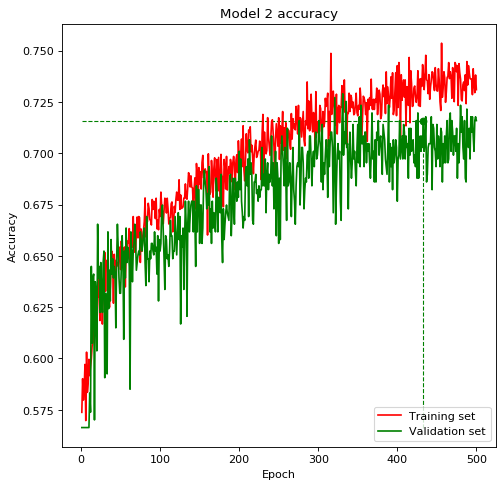

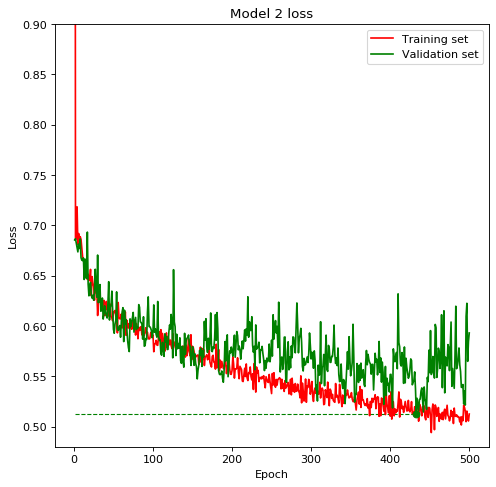

In [0]:
# Model accuracy
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('Model 2 accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.plot(epochs_2, tra_acc_2, 'r', label='Training set')
plt.plot(epochs_2, val_acc_2, 'g', label='Validation set')
plt.plot(opt_epoch_2, val_acc_2[opt_epoch_2-1], 'go')
plt.vlines(opt_epoch_2, min(val_acc_2), opt_val_acc_2, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_acc_2, 1, opt_epoch_2, linestyle="dashed", color='g', linewidth=1)
plt.legend(loc='lower right')

# Model loss
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('Model 2 loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.ylim(0.48,0.9)
plt.plot(epochs_2, tra_loss_2, 'r', label='Training set')
plt.plot(epochs_2, val_loss_2, 'g', label='Validation set')
plt.plot(opt_epoch_2, val_loss_2[opt_epoch_2-1], 'go')
plt.vlines(opt_epoch_2, min(val_loss_2), opt_val_loss_2, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_loss_2, 1, opt_epoch_2, linestyle="dashed", color='g', linewidth=1)
plt.legend();

## Run 3

In [0]:
# Model 3

model_3 = models.Sequential()
model_3.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=(150, 150, 1)))
model_3.add(layers.MaxPooling2D((2, 2)))
model_3.add(layers.Conv2D(128, (3, 3), activation='relu'))
model_3.add(layers.MaxPooling2D((2, 2)))
model_3.add(layers.Conv2D(256, (3, 3), activation='relu'))
model_3.add(layers.MaxPooling2D((2, 2)))
model_3.add(layers.Flatten())
model_3.add(layers.Dense(64, activation='relu'))
model_3.add(layers.Dropout(0.5))
model_3.add(layers.Dense(1, activation='sigmoid'))

model_3.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 148, 148, 64)      640       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 74, 74, 64)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 72, 72, 128)       73856     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 36, 36, 128)       0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 34, 34, 256)       295168    
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 17, 17, 256)       0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 73984)            

In [0]:
# Early stopping (stop training after the validation loss reaches the minimum)
earlystopping = EarlyStopping(monitor='val_loss', mode='min', patience=80, verbose=1)

# Callback for checkpointing
checkpoint = ModelCheckpoint('model_3_benmal_best.h5', 
        monitor='val_loss', mode='min', verbose=1, 
        save_best_only=True, save_freq='epoch'
)

# Compile the model
model_3.compile(optimizer=RMSprop(learning_rate=0.001, decay=1e-3), loss='binary_crossentropy', metrics=['accuracy'])

# Train
history_3 = model_3.fit_generator(
        train_generator,
        steps_per_epoch=int(0.8*n_train_img) // 128,
        epochs=500,
        validation_data=validation_generator,
        callbacks=[checkpoint],
        shuffle=True,
        verbose=1,
        initial_epoch=0
)

# Save
models.save_model(model_3, 'model_3_benmal_end.h5')
!cp model* "/content/gdrive/My Drive/models/"

Epoch 1/500
 4/16 [======>.......................] - ETA: 3s - loss: 0.7022 - acc: 0.5703
Epoch 00001: val_loss improved from inf to 0.71209, saving model to model_3_benmal_best.h5
16/16 [==============================] - 7s 459ms/step - loss: 1.1331 - acc: 0.5559 - val_loss: 0.7121 - val_acc: 0.5664
Epoch 2/500
 4/16 [======>.......................] - ETA: 3s - loss: 0.6877 - acc: 0.5703
Epoch 00002: val_loss improved from 0.71209 to 0.68978, saving model to model_3_benmal_best.h5
16/16 [==============================] - 6s 365ms/step - loss: 0.7068 - acc: 0.5733 - val_loss: 0.6898 - val_acc: 0.5664
Epoch 3/500
 4/16 [======>.......................] - ETA: 3s - loss: 0.6861 - acc: 0.5703
Epoch 00003: val_loss did not improve from 0.68978
16/16 [==============================] - 6s 376ms/step - loss: 0.6939 - acc: 0.5857 - val_loss: 0.6899 - val_acc: 0.5664
Epoch 4/500
 4/16 [======>.......................] - ETA: 4s - loss: 0.6770 - acc: 0.5703
Epoch 00004: val_loss improved from 0.68

In [0]:
# History of accuracy and loss
tra_loss_3 = history_3.history['loss']
tra_acc_3 = history_3.history['acc']
val_loss_3 = history_3.history['val_loss']
val_acc_3 = history_3.history['val_acc']

# Total number of epochs training
epochs_3 = range(1, len(tra_acc_3)+1)
end_epoch_3 = len(tra_acc_3)

# Epoch when reached the validation loss minimum
opt_epoch_3 = val_loss_3.index(min(val_loss_3)) + 1

# Loss and accuracy on the validation set
end_val_loss_3 = val_loss_3[-1]
end_val_acc_3 = val_acc_3[-1]
opt_val_loss_3 = val_loss_3[opt_epoch_3-1]
opt_val_acc_3 = val_acc_3[opt_epoch_3-1]

# Loss and accuracy on the test set
opt_model_3 = models.load_model('model_3_benmal_best.h5')
test_loss_3, test_acc_3 = model_3.evaluate(test_images, test_labels, verbose=False)
opt_test_loss_3, opt_test_acc_3 = opt_model_3.evaluate(test_images, test_labels, verbose=False)
opt_pred_3 = opt_model_3.predict([test_images, test_labels])
pred_classes_3 = np.rint(opt_pred_3)

print("Model 3\n")

print("Epoch [end]: %d" % end_epoch_3)
print("Epoch [opt]: %d" % opt_epoch_3)
print("Valid accuracy [end]: %.4f" % end_val_acc_3)
print("Valid accuracy [opt]: %.4f" % opt_val_acc_3)
print("Test accuracy [end]:  %.4f" % test_acc_3)
print("Test accuracy [opt]:  %.4f" % opt_test_acc_3)
print("Valid loss [end]: %.4f" % end_val_loss_3)
print("Valid loss [opt]: %.4f" % opt_val_loss_3)
print("Test loss [end]:  %.4f" % test_loss_3)
print("Test loss [opt]:  %.4f" % opt_test_loss_3)

print(classification_report(test_labels, pred_classes_3, digits=4))

Model 3

Epoch [end]: 500
Epoch [opt]: 419
Valid accuracy [end]: 0.6953
Valid accuracy [opt]: 0.6897
Test accuracy [end]:  0.6577
Test accuracy [opt]:  0.6905
Valid loss [end]: 0.5761
Valid loss [opt]: 0.5248
Test loss [end]:  0.6358
Test loss [opt]:  0.5918
              precision    recall  f1-score   support

           0     0.7602    0.7671    0.7636       219
           1     0.5565    0.5470    0.5517       117

    accuracy                         0.6905       336
   macro avg     0.6584    0.6571    0.6577       336
weighted avg     0.6893    0.6905    0.6898       336



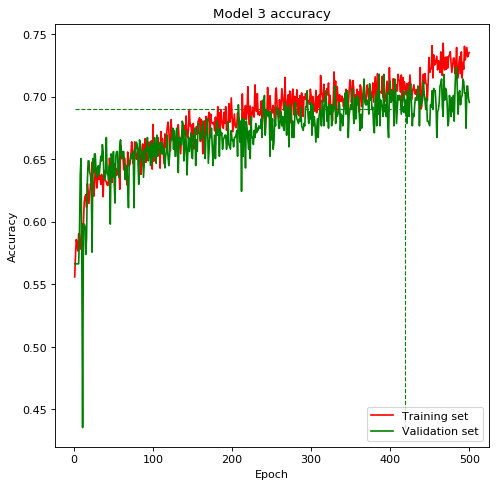

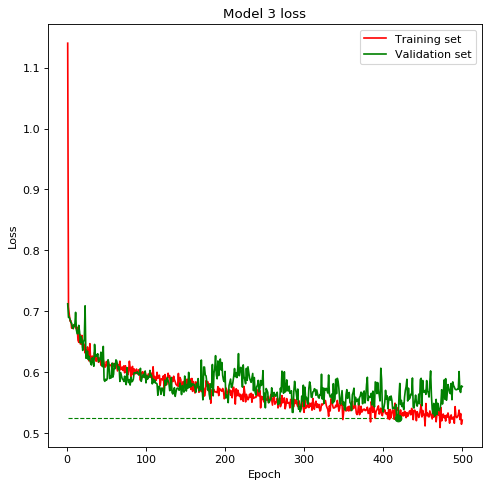

In [0]:
# Model accuracy
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('Model 3 accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.plot(epochs_3, tra_acc_3, 'r', label='Training set')
plt.plot(epochs_3, val_acc_3, 'g', label='Validation set')
plt.plot(opt_epoch_3, val_acc_3[opt_epoch_3-1], 'go')
plt.vlines(opt_epoch_3, min(val_acc_3), opt_val_acc_3, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_acc_3, 1, opt_epoch_3, linestyle="dashed", color='g', linewidth=1)
plt.legend(loc='lower right')

# Model loss
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('Model 3 loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(epochs_3, tra_loss_3, 'r', label='Training set')
plt.plot(epochs_3, val_loss_3, 'g', label='Validation set')
plt.plot(opt_epoch_3, val_loss_3[opt_epoch_3-1], 'go')
plt.vlines(opt_epoch_3, min(val_loss_3), opt_val_loss_3, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_loss_3, 1, opt_epoch_3, linestyle="dashed", color='g', linewidth=1)
plt.legend();